In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


In [2]:
#Cargando los datos
df = pd.read_csv('../csv_files/historic_data.csv')

In [3]:


# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("date")[['24h_avg']]
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

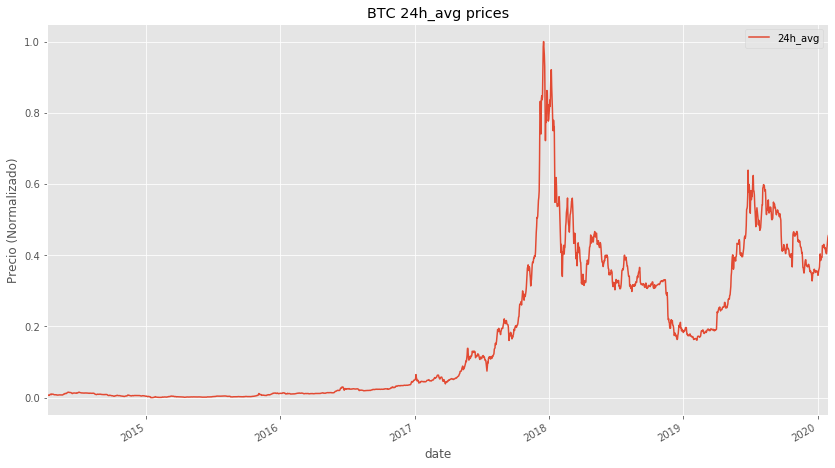

In [4]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC 24h_avg prices")
plt.ylabel("Precio (Normalizado)")
plt.show()

In [5]:
def split_sequence(seq, n_steps_in, n_steps_out):
    '''
    Separa las univariantes de las secuencias del tiempo
    Creando dos arrays que sirven como entrada y salida de la red neuronal
    X sirve como datos pasados para entrenar
    y sirve como datos futuros para predecir
    '''
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [6]:
def visualize_training_results(results):
    '''
    Muestra la perdida y la exactitud de los datos de entrenamiento y testeo
    '''
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [16]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    '''
    Crea un número específico de capas ocultas para una red neuronal recurrente.
    Opcional: Agrega una opción de regularización, elimina capas para prevenir sobre entrenamiento
    '''
    
    #Creando el número específico de capas ocultas con el número de nodos definido.
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        #Añadiendo la opción de eliminar una capa despues de cierto número de capas ocultas
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [17]:
#Separando los datos con la función split_seq

#Periodos de entrenamiento
n_per_in  = 2050

#Número de periodos a predecir
n_per_out = 15

#Features (en este caso solo es una[24_h_avg])
n_features = 1

#Separando la data en secuencias apropiadas
X, y = split_sequence(list(df['24h_avg']), n_per_in, n_per_out)
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [18]:
X.shape

(59, 2050, 1)

In [23]:
#Iniciando el modelo
model = Sequential()

#Activación
activ = 'softsign'

#Input Layer
model.add(LSTM(15, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

#Capas ocultas
layer_maker(n_layers=6, n_nodes=12, activation=activ)

#Capa oculta final
model.add(LSTM(15, activation=activ))

#Output layer
model.add(Dense(n_per_out))

#Model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 2050, 15)          1020      
_________________________________________________________________
lstm_13 (LSTM)               (None, 2050, 12)          1344      
_________________________________________________________________
lstm_14 (LSTM)               (None, 2050, 12)          1200      
_________________________________________________________________
lstm_15 (LSTM)               (None, 2050, 12)          1200      
_________________________________________________________________
lstm_16 (LSTM)               (None, 2050, 12)          1200      
_________________________________________________________________
lstm_17 (LSTM)               (None, 2050, 12)          1200      
_________________________________________________________________
lstm_18 (LSTM)               (None, 2050, 12)         

In [24]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [28]:
res = model.fit(X, y, epochs=364, batch_size=32, validation_split=0.1)

Train on 53 samples, validate on 6 samples
Epoch 1/364
53/53 [==============================] - 20s 368ms/step - loss: 5.5371e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 2/364
53/53 [==============================] - 22s 413ms/step - loss: 5.5203e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 3/364
53/53 [==============================] - 22s 409ms/step - loss: 5.5267e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 4/364
53/53 [==============================] - 26s 484ms/step - loss: 5.5388e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 5/364
53/53 [==============================] - 26s 489ms/step - loss: 5.5499e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 6/364
53/53 [==============================] - 26s 485ms/step - loss: 5.5428e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 7/364
53/53 [==============================] - 25s 475ms/st

53/53 [==============================] - 18s 335ms/step - loss: 5.5283e-04 - accuracy: 0.0755 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 56/364
53/53 [==============================] - 18s 341ms/step - loss: 5.5622e-04 - accuracy: 0.0755 - val_loss: 0.0026 - val_accuracy: 0.5000
Epoch 57/364
53/53 [==============================] - 18s 340ms/step - loss: 5.5319e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 58/364
53/53 [==============================] - 18s 337ms/step - loss: 5.5513e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 59/364
53/53 [==============================] - 18s 339ms/step - loss: 5.5338e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 60/364
53/53 [==============================] - 18s 339ms/step - loss: 5.5355e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 61/364
53/53 [==============================] - 18s 335ms/step - loss: 5.5273e-04 - accuracy: 0.1321 - val_lo

Epoch 110/364
53/53 [==============================] - 21s 404ms/step - loss: 5.5315e-04 - accuracy: 0.0755 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 111/364
53/53 [==============================] - 21s 402ms/step - loss: 5.5437e-04 - accuracy: 0.0755 - val_loss: 0.0026 - val_accuracy: 0.5000
Epoch 112/364
53/53 [==============================] - 21s 405ms/step - loss: 5.5358e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 113/364
53/53 [==============================] - 21s 402ms/step - loss: 5.5425e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 114/364
53/53 [==============================] - 21s 402ms/step - loss: 5.5442e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 115/364
53/53 [==============================] - 21s 402ms/step - loss: 5.5249e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 116/364
53/53 [==============================] - 21s 404ms/step - loss: 5.5546e-04 - accur

53/53 [==============================] - 25s 475ms/step - loss: 5.5278e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 165/364
53/53 [==============================] - 25s 474ms/step - loss: 5.5458e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 166/364
53/53 [==============================] - 26s 493ms/step - loss: 5.5394e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 167/364
53/53 [==============================] - 27s 514ms/step - loss: 5.5251e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 168/364
53/53 [==============================] - 26s 497ms/step - loss: 5.5320e-04 - accuracy: 0.1321 - val_loss: 0.0026 - val_accuracy: 0.5000
Epoch 169/364
53/53 [==============================] - 26s 494ms/step - loss: 5.5274e-04 - accuracy: 0.1321 - val_loss: 0.0026 - val_accuracy: 0.5000
Epoch 170/364
53/53 [==============================] - 26s 484ms/step - loss: 5.5253e-04 - accuracy: 0.1321 - val_

53/53 [==============================] - 20s 372ms/step - loss: 5.5333e-04 - accuracy: 0.0755 - val_loss: 0.0026 - val_accuracy: 0.5000
Epoch 219/364
53/53 [==============================] - 20s 370ms/step - loss: 5.5292e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 220/364
53/53 [==============================] - 20s 368ms/step - loss: 5.5241e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 221/364
53/53 [==============================] - 20s 371ms/step - loss: 5.5302e-04 - accuracy: 0.1321 - val_loss: 0.0029 - val_accuracy: 0.5000
Epoch 222/364
53/53 [==============================] - 20s 382ms/step - loss: 5.5691e-04 - accuracy: 0.1321 - val_loss: 0.0029 - val_accuracy: 0.5000
Epoch 223/364
53/53 [==============================] - 22s 417ms/step - loss: 5.5575e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 224/364
53/53 [==============================] - 19s 359ms/step - loss: 5.5488e-04 - accuracy: 0.0755 - val_

53/53 [==============================] - 18s 336ms/step - loss: 5.5207e-04 - accuracy: 0.0755 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 273/364
53/53 [==============================] - 18s 338ms/step - loss: 5.5575e-04 - accuracy: 0.0755 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 274/364
53/53 [==============================] - 18s 335ms/step - loss: 5.5552e-04 - accuracy: 0.0755 - val_loss: 0.0026 - val_accuracy: 0.5000
Epoch 275/364
53/53 [==============================] - 18s 337ms/step - loss: 5.5417e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 276/364
53/53 [==============================] - 18s 337ms/step - loss: 5.5250e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 277/364
53/53 [==============================] - 18s 337ms/step - loss: 5.5262e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 278/364
53/53 [==============================] - 18s 339ms/step - loss: 5.5401e-04 - accuracy: 0.132

53/53 [==============================] - 18s 349ms/step - loss: 5.5278e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 327/364
53/53 [==============================] - 19s 349ms/step - loss: 5.5417e-04 - accuracy: 0.1321 - val_loss: 0.0028 - val_accuracy: 0.5000
Epoch 328/364
53/53 [==============================] - 18s 346ms/step - loss: 5.5371e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 329/364
53/53 [==============================] - 18s 347ms/step - loss: 5.5277e-04 - accuracy: 0.1321 - val_loss: 0.0027 - val_accuracy: 0.5000
Epoch 330/364
53/53 [==============================] - 19s 356ms/step - loss: 5.5221e-04 - accuracy: 0.1321 - val_loss: 0.0026 - val_accuracy: 0.5000
Epoch 331/364
53/53 [==============================] - 18s 345ms/step - loss: 5.5928e-04 - accuracy: 0.1321 - val_loss: 0.0025 - val_accuracy: 0.5000
Epoch 332/364
53/53 [==============================] - 21s 399ms/step - loss: 5.5597e-04 - accuracy: 0.1321 - val_

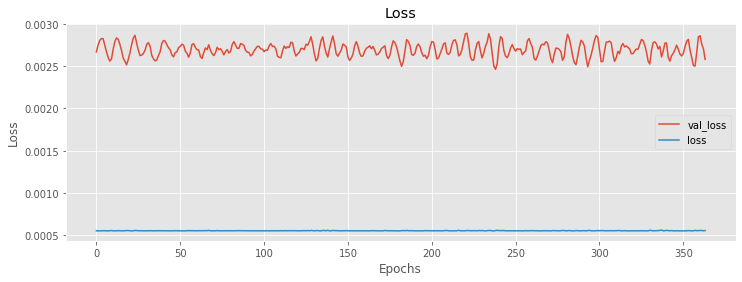

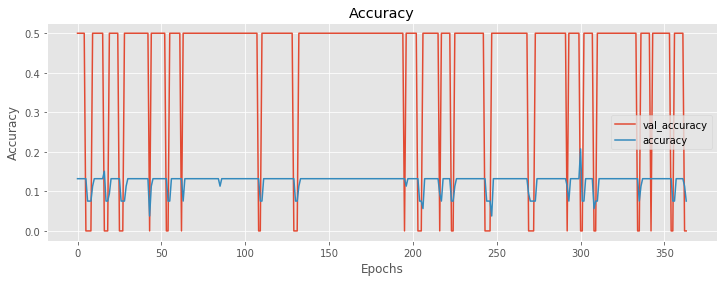

In [29]:
visualize_training_results(res)

Predicted Prices:
 [[142107.0231390344], [141813.7135129922], [141497.63308418886], [141644.43473274363], [142354.8928149238], [142880.66568086031], [143324.8883504003], [143425.35774055915], [144497.31361161338], [144423.71512411756], [144828.95860698656], [145276.52460867798], [144910.63304883466], [145721.07483440847], [145424.01525473697]]

Actual Prices:
 [[165520.37209999998], [166147.93867782428], [164527.6093716475], [161652.27971111113], [162367.29661818186], [162376.88145454545], [158128.54111790395], [157778.16799052132], [156203.1393], [159235.87872990352], [161008.54136363638], [164784.204151957], [169735.56765079364], [173549.83008683068], [175469.3664956737]]


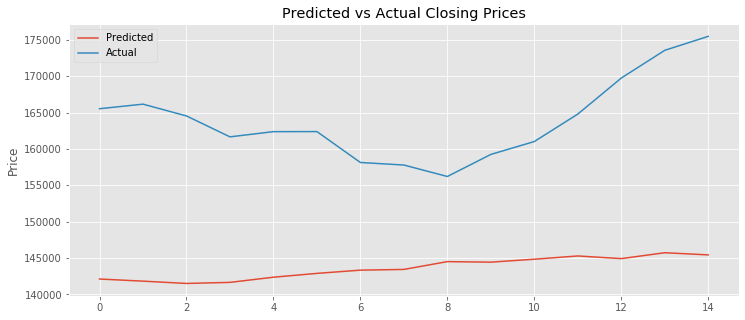

In [30]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_validation.png")
plt.show()

                  24h_avg
2020-01-30  142108.559265
2020-01-31  141814.797837
2020-02-01  141498.423737
2020-02-02  141645.247976
2020-02-03  142356.553186
2020-02-04  142882.179216
2020-02-05  143325.972674
2020-02-06  143426.306524
2020-02-07  144498.883622
2020-02-08  144424.822038
2020-02-09  144830.765814
2020-02-10  145277.281376
2020-02-11  144910.666934
2020-02-12  145723.153122
2020-02-13  145425.528790


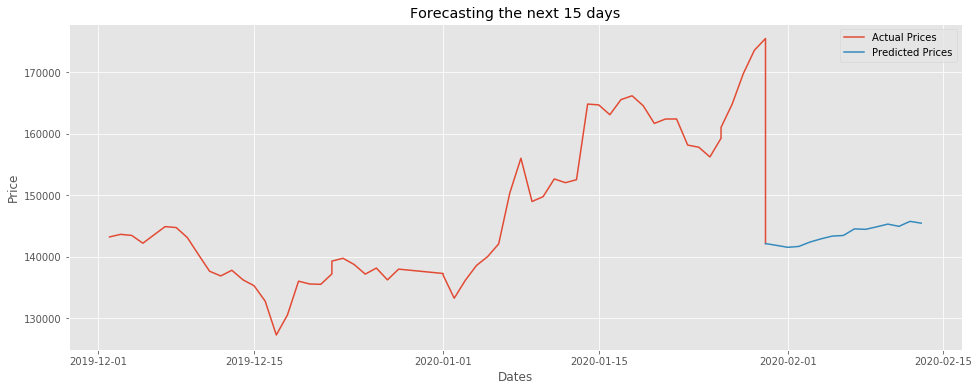

In [31]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 60

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["24h_avg"]].tail(pers)), index=df['24h_avg'].tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()

In [ ]:
import